# Important: Get kagggle.json before running the notebook
Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab.


In [1]:
#@title Setup for colab { display-mode: "form" }

%%capture
!sudo apt-get install subversion
!svn checkout https://github.com/probml/pyprobml/trunk/scripts/vae .

**Warning**: If you are running this on your local machine please follow the readme instructions to first download the subdirectory before using this notebook, instead of running the "setup for colab" file.

In [2]:
#@title Run Setup And Installation { display-mode: "form" }

%%capture
!pip install pytorch-lightning einops
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/two_stage_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/hinge_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/info_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/logcosh_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/mmd_vae_celeba_conv.ckpt
!wget -q https://github.com/probml/probml-data/raw/main/checkpoints/vanilla_vae_celeba_conv.ckpt

import torch
import warnings
import torchvision.transforms as transforms
from data import  CelebADataModule
from assembler import assembler
from utils import get_config, plot_reconstruction, plot_samples

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def make_model(model_name, use_gpu=False):
  fname = f"./configs/{model_name}.yaml"
  config = get_config(fname)
  vae = assembler(config, "inference")
  if use_gpu: vae = vae.to("cuda")
  return vae

def make_and_load_models(model_names: list, use_gpu=False):
  vaes = []
  for model_name in model_names:
    vae = make_model(model_name, use_gpu)
    vae.load_model()
    vaes.append(vae)
  return vaes 

# Download data and load data module

## Put kagggle.json key to colab **warning: only for colab**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
#@title Download celeba and load datamodule { display-mode: "form" }

!ls
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!rm kaggle.json

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

trans = []
trans.append(transforms.RandomHorizontalFlip())
if CROP > 0:
  trans.append(transforms.CenterCrop(CROP))
trans.append(transforms.Resize(IMAGE_SIZE))
trans.append(transforms.ToTensor())
transform = transforms.Compose(trans)

dm = CelebADataModule(data_dir=DATA_PATH,
                            target_type='attr',
                            train_transform=transform,
                            val_transform=transform,
                            download=True,
                            batch_size=bs)

dm.prepare_data() # force download now
dm.setup() # force make data loaders n

batch = next(iter(dm.train_dataloader()))
x, y = batch 

assembler.py		      models
configs			      __pycache__
data.py			      README.md
experiment.py		      results.ipynb
hinge_vae_celeba_conv.ckpt    run.py
info_vae_celeba_conv.ckpt     sample_data
kaggle.json		      two_stage_vae_celeba_conv.ckpt
logcosh_vae_celeba_conv.ckpt  utils.py
mmd_vae_celeba_conv.ckpt      vanilla_vae_celeba_conv.ckpt


  0%|          | 0.00/1.33G [00:00<?, ?B/s]

100%|██████████| 1.33G/1.33G [00:22<00:00, 63.2MB/s]


100%|██████████| 2.02M/2.02M [00:00<00:00, 136MB/s]


100%|██████████| 1.54M/1.54M [00:00<00:00, 94.4MB/s]


100%|██████████| 466k/466k [00:00<00:00, 60.5MB/s]


  0%|          | 0.00/2.07M [00:00<?, ?B/s]

100%|██████████| 2.07M/2.07M [00:00<00:00, 9.33MB/s]



Done!


# Comparing results

In [5]:
models_to_compare = ["vanilla_vae", "info_vae", "hinge_vae", "mmd_vae", "logcosh_vae", "two_stage_vae"]
figsize_reconstruction = (10, 30)
figsize_samples = (10, 10)

vaes = make_and_load_models(models_to_compare, use_gpu = True)

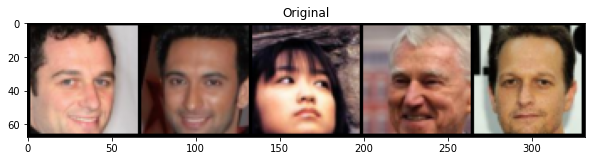

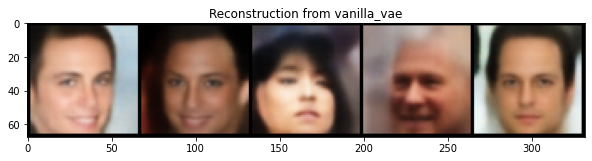

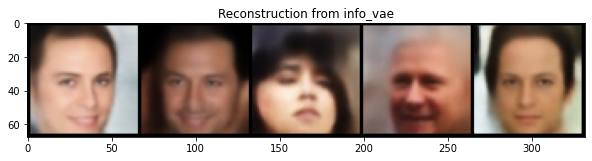

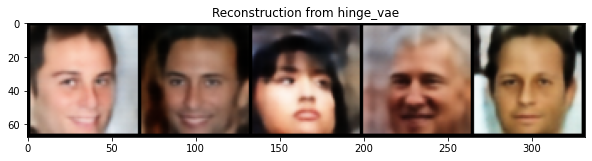

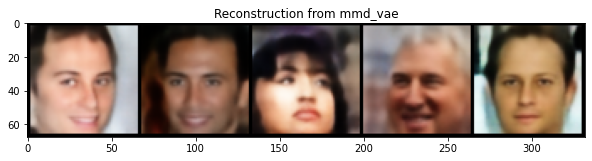

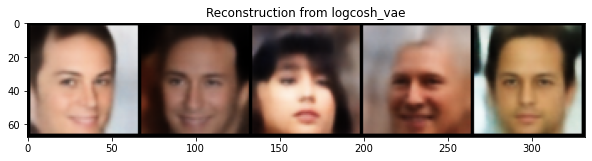

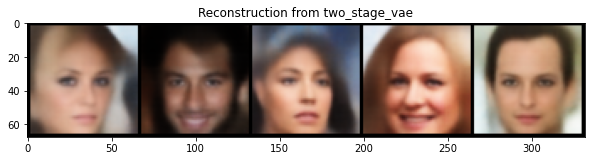

In [6]:
#@title Compare Reconstruction 

num_imgs = 5 #@param {type:"slider", min:1, max:20, step:1}
plot_reconstruction(vaes, batch, num_of_samples=num_imgs)

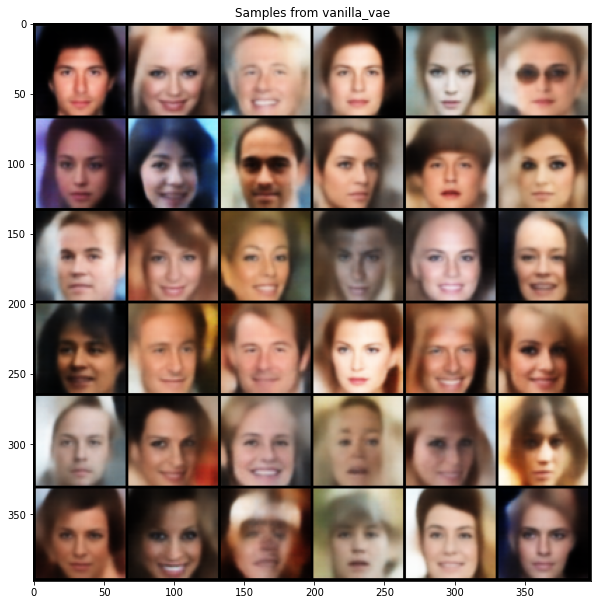

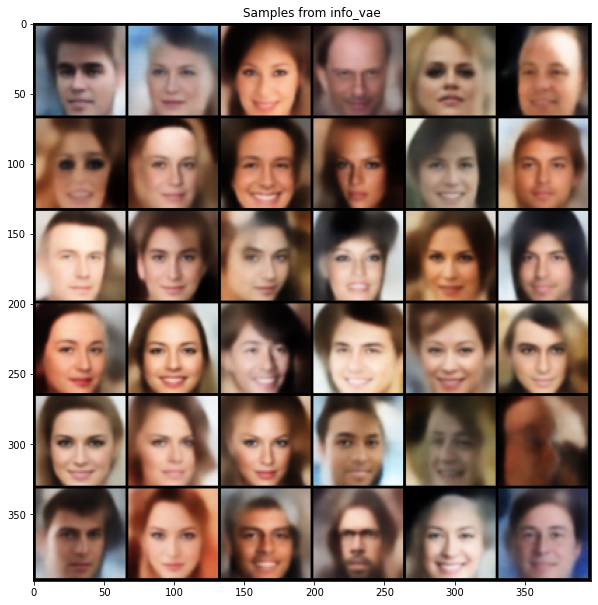

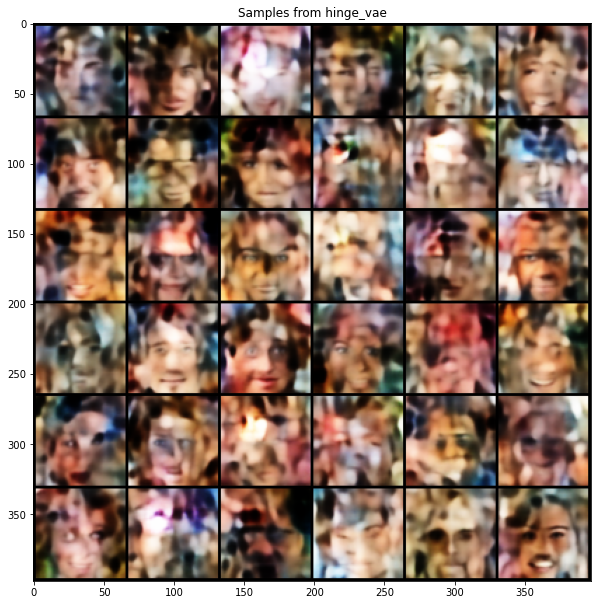

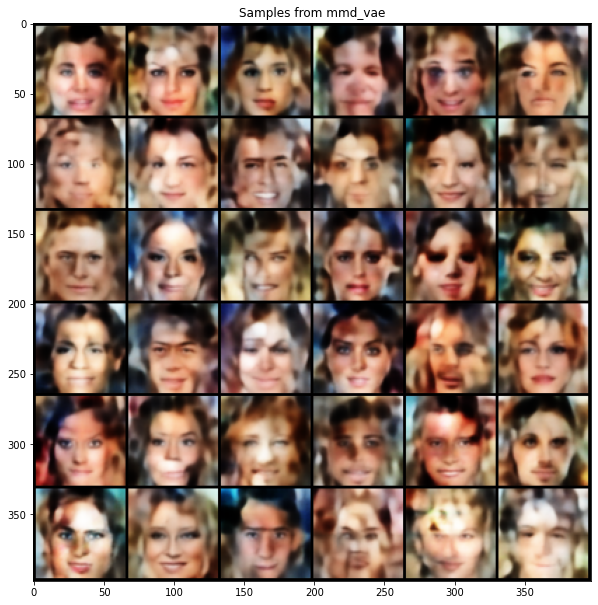

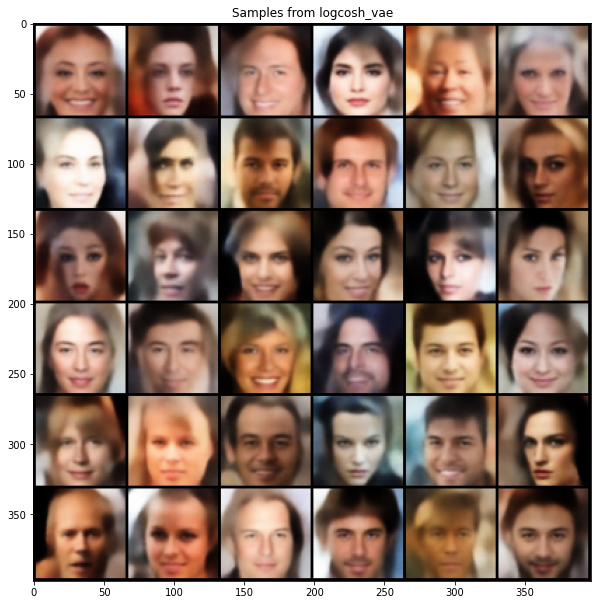

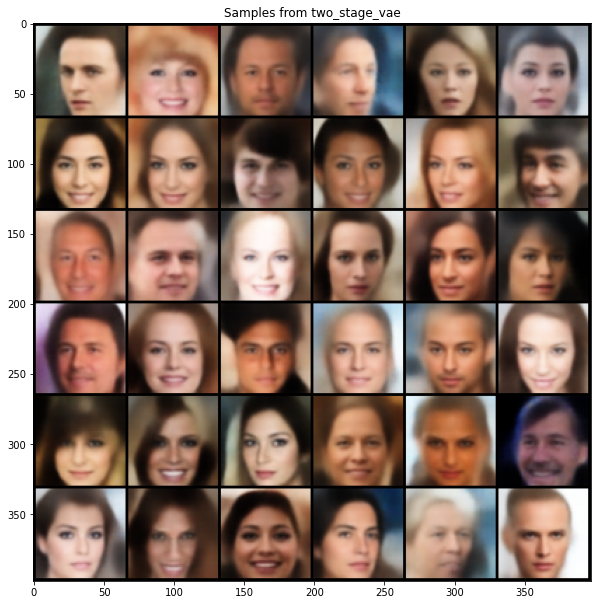

In [8]:
#@title Compare Samples

num_imgs = 36 #@param  {type:"slider", min:1, max:100, step:1}
num_of_images_per_row = 6 #@param  {type:"slider", min:1, max:100, step:1}

plot_samples(vaes, num=num_imgs, num_of_images_per_row=num_of_images_per_row)